In [23]:
import numpy as np
import tigre
import tigre.algorithms as algs
import matplotlib.pyplot as plt
from numpy import genfromtxt
from matplotlib.pyplot import figure
from skimage.transform import iradon
import matplotlib
import astra
import scipy as sp
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
%matplotlib inline

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

#Geometry--------------------------------------------------------------------------
geo = tigre.geometry()
# VARIABLE                                   DESCRIPTION                    UNITS
# -------------------------------------------------------------------------------------
# Distances
geo.DSD = 1086 # Distance Source Detector      (mm)
geo.DSO = 626 # Distance Source Origin        (mm)
# Image parameters
geo.nVoxel = np.array([1, 512, 512])  # number of voxels              (vx)
geo.sVoxel = np.array([1, 120, 120])  # total size of the image       (mm)
geo.dVoxel = geo.sVoxel / geo.nVoxel  # size of each voxel            (mm)
# Detector parameters
geo.nDetector = np.array([1, 96])  # number of pixels              (px)
geo.dDetector = np.array([geo.dVoxel[0], 1.25])  # size of each pixel            (mm)
geo.sDetector = geo.nDetector * geo.dDetector  # total size of the detector    (mm)
# Offsets
geo.offOrigin = np.array([0, 0, 0])  # Offset of image from origin   (mm)
geo.offDetector = np.array([0, 0])  # Offset of Detector            (mm)
# MAKE SURE THAT THE DETECTOR PIXELS SIZE IN V IS THE SAME AS THE IMAGE!

# Offsets
geo.offOrigin = np.array([0, 0, 0])  # Offset of image from origin   (mm)
geo.offDetector = np.array([0, 0])  # Offset of Detector            (mm)

geo.mode = "parallel"

angles = np.arange(0,2*np.pi,(2*np.pi)/45)
theta=angles


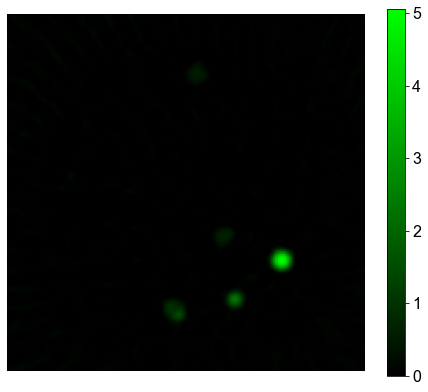

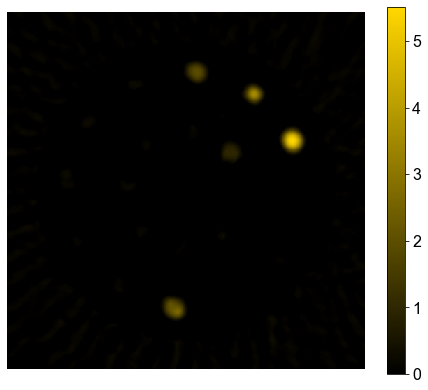

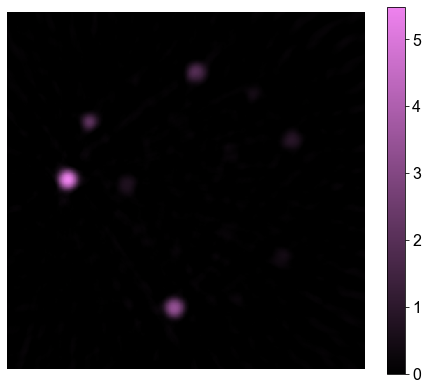

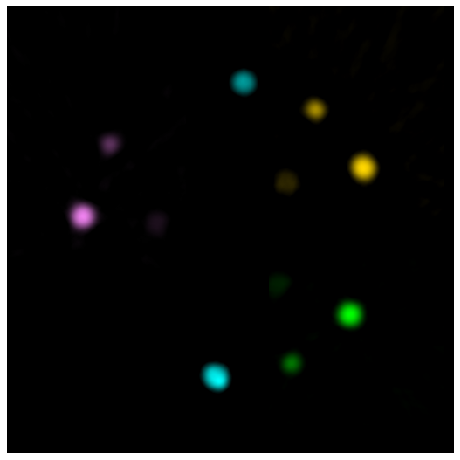

In [46]:
bin_width=0.8
bins=np.arange(27,100,bin_width)
master_counts=np.load("Desktop/CT imaging/master_counts_strip_8deg.npy")
master_counts=np.squeeze(master_counts)
master_binned=np.zeros((45,96,int(np.ceil(len(bins)))))
for k in np.arange(0,len(bins)):
    for i in np.arange(0,45):
        for j in np.arange(0,96):
            master_binned[i][j][k]=master_counts[i][j][int(np.around((bins[0]+bin_width*k)/0.2)):int(np.around((((bins[0]+bin_width*(k+1))/0.2))))].mean()
master_binned=np.transpose(master_binned)
master_counts=master_binned
master_counts=np.swapaxes(master_counts,1,2)
for i in np.arange(0,len(master_counts)):
    master_counts[i][4]=np.insert(master_counts[i][4][:-1],0,0)
    master_counts[i][38]=np.insert(master_counts[i][38][:-1],0,0)
master_counts=np.swapaxes(master_counts,1,2)

#forming the image array
theta=np.arange(0,360,8)
images=[]
for i in np.arange(0,len(bins)):
    img=algs.fdk(np.copy((np.array(master_counts[i]).T)[:,np.newaxis,:]).astype(np.float32), geo, angles, filter='hann')
    images.append(img.T)
    images[i][images[i]<0]=0

# Collect NIST photon cross section data
mu_Gd=genfromtxt("Desktop/CT imaging/linear attenuation coefficients/Gd_Mu.txt",skip_header=2)
energy_Gd = mu_Gd[::2]*1000
mu_Gd = mu_Gd[1::2]
density_Gd=7.901
mu_Gd= density_Gd*mu_Gd

mu_I=genfromtxt("Desktop/CT imaging/linear attenuation coefficients/I_Mu.txt",skip_header=2)
energy_I = mu_I[::2]*1000
mu_I = mu_I[1::2]
density_I=4.93
mu_I=density_I*mu_I

mu_Au=genfromtxt("Desktop/CT imaging/linear attenuation coefficients/Au_Mu.txt",skip_header=2)
energy_Au = mu_Au[::2]*1000
mu_Au = mu_Au[1::2]
density_Au=19.3
mu_Au=density_Au*mu_Au

mu_Ph=genfromtxt("Desktop/CT imaging/linear attenuation coefficients/Ph_Mu.txt",skip_header=2)
energy_Ph = mu_Ph[::2]*1000
mu_Ph = mu_Ph[1::2]
density_Ph=0.95
mu_Ph=density_Ph*mu_Ph



#Linear interpolation at correct energies
new_mu_Gd=np.interp(bins+bin_width/2,energy_Gd,mu_Gd)
new_mu_Au=np.interp(bins+bin_width/2,energy_Au,mu_Au)
new_mu_I=np.interp(bins+bin_width/2,energy_I,mu_I)
new_mu_Ph=np.interp(bins+bin_width/2,energy_Ph,mu_Ph)



mu_all=[new_mu_Gd,new_mu_Ph,new_mu_I,new_mu_Au]
images=np.transpose(images)
images=np.squeeze(images)

new_images=[]
for i in np.arange(0,512):
    for j in np.arange(0,512):
         new_images.append(np.linalg.lstsq(np.transpose(mu_all),images[j][i],rcond=None)[0])
            

Gd_image=[];Au_image=[];Ph_image=[];I_image=[]
for i in np.arange(0,262144):
    Gd_image.append(new_images[i][0])
    Ph_image.append(new_images[i][1])
    I_image.append(new_images[i][2])
    Au_image.append(new_images[i][3])

Au_image = [Au_image[i:i+512] for i in range(0, len(Au_image), 512)]
Gd_image = [Gd_image[i:i+512] for i in range(0, len(Gd_image), 512)]
Ph_image = [Ph_image[i:i+512] for i in range(0, len(Ph_image), 512)]
I_image = [I_image[i:i+512] for i in range(0, len(I_image), 512)]
Gd_image=np.array(Gd_image)
Au_image=np.array(Au_image)
I_image=np.array(I_image)
Ph_image=np.array(Ph_image)
Gd_image[Gd_image<0] = 0
Au_image[Au_image<0] = 0
I_image[I_image<0] = 0
Ph_image[Ph_image<0]=0



#Normalize---------------------------------------------------------------------------------------------------
I_image=I_image*5/0.0016099929139490002*5/5.8688754224640824*5/4.439123971225828
Gd_image=Gd_image*5/0.0011404768836861805*5/5.094416684253784
Au_image=Au_image*5/0.00032658278172994544*5/3.781992672156292
#Create colormaps--------------------------------------------------------------------------------------------
cmap = LinearSegmentedColormap.from_list(name='lime',colors=['black','lime'])
plt.register_cmap('lime', cmap)
cmap = LinearSegmentedColormap.from_list(name='violet',colors=['black','violet'])
plt.register_cmap('violet', cmap)
cmap = LinearSegmentedColormap.from_list(name='gold',colors=['black','gold'])
plt.register_cmap('gold', cmap)
cmap = LinearSegmentedColormap.from_list(name='brown',colors=['black','cyan'])
plt.register_cmap('brown', cmap)
cmap = LinearSegmentedColormap.from_list(name='all',colors=['black','lime','black','violet','black','gold','black','cyan'])
plt.register_cmap('all', cmap)

#Plot
figure(2,figsize=(8,9))
plt.imshow(Gd_image,aspect='equal',cmap='lime')
plt.colorbar(shrink=0.75)
plt.axis('off')


# figure(3,figsize=(8,9))
# plt.imshow(Ph_image,aspect='equal',cmap='gray')
# plt.colorbar(shrink=0.75)
# plt.ginput(-1,timeout=-8)


figure(4,figsize=(8,9))
plt.imshow(Au_image,aspect='equal',cmap='gold')
plt.colorbar(shrink=0.75)
plt.axis('off')

figure(5,figsize=(8,9))
plt.imshow(I_image,aspect='equal',cmap='violet')
plt.colorbar(shrink=0.75)
plt.axis('off')

Auarea=[[i+300,j+0] for i in np.arange(0,200) for j in np.arange(0,250)]
Gdarea=[[i+300,j+280] for i in np.arange(0,200) for j in np.arange(0,200)]
Iarea=[[i+0,j+0] for i in np.arange(0,205) for j in np.arange(0,300)]
Mixarea=[[i+210,j+0] for i in np.arange(0,90) for j in np.arange(0,512)]

mask=np.zeros(shape=(512,512))
for x,y in Auarea:
    mask[int(y)][int(x)]=1
Auarea=mask*Au_image

mask=np.zeros(shape=(512,512))
for x,y in Gdarea:
    mask[int(y)][int(x)]=1
Gdarea=mask*Gd_image

mask=np.zeros(shape=(512,512))
for x,y in Iarea:
    mask[int(y)][int(x)]=1
Iarea=mask*I_image

mask=np.zeros(shape=(512,512))
tot_image=I_image+Gd_image+Au_image
for x,y in Mixarea:
    mask[int(y)][int(x)]=1
Mixarea=mask*tot_image

Auarea = np.ma.masked_where(Auarea <0.0005*100, Auarea)
Iarea = np.ma.masked_where(Iarea <0.0005*100, Iarea)
Gdarea = np.ma.masked_where(Gdarea <0.0005*100, Gdarea)
Mixarea=np.ma.masked_where(Mixarea <0.005*100, Mixarea)

figure(6,figsize=(8,9))
plt.imshow(np.zeros((512,512)),cmap='violet')
plt.imshow(Auarea,cmap='gold')
plt.imshow(Gdarea,cmap='lime')
plt.imshow(Iarea,cmap='violet')
plt.imshow(Mixarea,cmap='brown')
plt.axis('off')

#Vial coordinates 512x512
coordsI5 =[[i+82,j+238] for i in np.arange(0,10) for j in np.arange(0,10)] 
coordsI3 =[[i+116,j+156] for i in np.arange(0,5) for j in np.arange(0,5)]
coordsI1=[[i+174,j+248] for i in np.arange(0,5) for j in np.arange(0,5)]
coordsGd5=[[i+388,j+349] for i in np.arange(0,10) for j in np.arange(0,10)] 
coordsGd3=[[i+327,j+412] for i in np.arange(0,5) for j in np.arange(0,5)]
coordsGd1=[[i+313,j+321] for i in np.arange(0,5) for j in np.arange(0,5)]
coordsAu5=[[i+406,j+183] for i in np.arange(0,10) for j in np.arange(0,10)] 
coordsAu3=[[i+352,j+116] for i in np.arange(0,5) for j in np.arange(0,5)]
coordsAu1=[[i+319,j+203] for i in np.arange(0,5) for j in np.arange(0,5)]
coordsMix33=[[i+239,j+426] for i in np.arange(0,10) for j in np.arange(0,10)]
coordsMix2=[[i+268,j+88] for i in np.arange(0,10) for j in np.arange(0,10)]
coords0=[[i+185,j+101] for i in np.arange(0,5) for j in np.arange(0,5)]
coords01=[[i+260,j+170] for i in np.arange(0,5) for j in np.arange(0,5)]
coords02=[[i+188,j+310] for i in np.arange(0,5) for j in np.arange(0,5)]
coords03=[[i+244,j+345] for i in np.arange(0,5) for j in np.arange(0,5)]

5% I 4.999999999999999
3% I 2.0836789513358536
1% I 0.6043179230259358
3.3% I 2.4455713401626102
2% I 1.4579052407781707
0% I 0.08748014234017118
0.949291171749789


Text(0, 0.5, 'CNR')

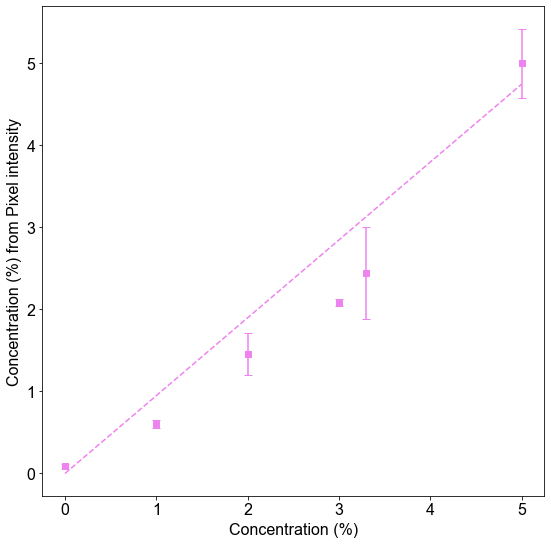

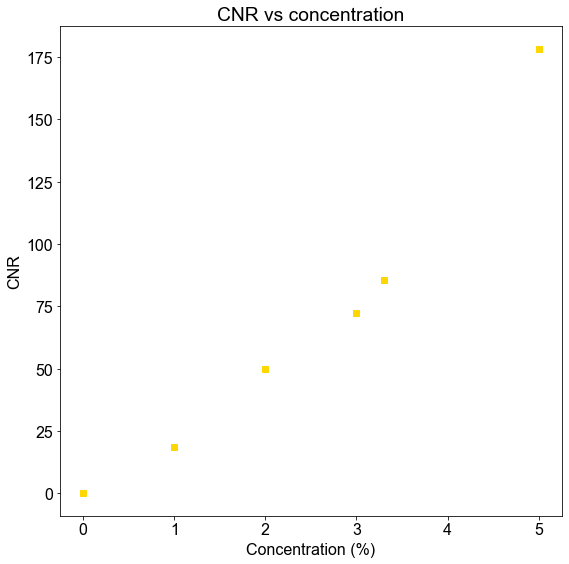

In [47]:
#Linearity + CNR calculations---------------------------------------------------------------------


mask=np.zeros(shape=(512,512))
for x,y in coordsAu5:
    mask[int(y)][int(x)]=1
vial1=mask*Au_image
vial1[vial1==0]=np.nan
vial1_mean=np.nanmean(vial1)
vial1_std=np.nanstd(vial1)
print('5% I', vial1_mean)

mask=np.zeros(shape=(512,512))
for x,y in coordsI3:
    mask[int(y)][int(x)]=1
vial2=mask*I_image
vial2[vial2==0]=np.nan
vial2_mean=np.nanmean(vial2)
vial2_std=np.nanstd(vial2)
print('3% I', vial2_mean)

mask=np.zeros(shape=(512,512))
for x,y in coordsI1:
    mask[int(y)][int(x)]=1
vial3=mask*I_image
vial3[vial3==0]=np.nan
vial3_mean=np.nanmean(vial3)
vial3_std=np.nanstd(vial3)
print('1% I', vial3_mean)


mask=np.zeros(shape=(512,512))
for x,y in coordsMix33:
    mask[int(y)][int(x)]=1
vial4=mask*I_image
vial4[vial4==0]=np.nan
vial4_mean=np.nanmean(vial4)
vial4_std=np.nanstd(vial4)
print('3.3% I', vial4_mean)

mask=np.zeros(shape=(512,512))
for x,y in coordsMix2:
    mask[int(y)][int(x)]=1
vial5=mask*I_image
vial5[vial5==0]=np.nan
vial5_mean=np.nanmean(vial5)
vial5_std=np.nanstd(vial5)
print('2% I', vial5_mean)

mask=np.zeros(shape=(512,512))
for x,y in coords0:
    mask[int(y)][int(x)]=1
vial6=mask*I_image
if (vial6==0).all()==False:
    vial6[vial6==0]=np.nan
    vial6_mean=np.nanmean(vial6)
    vial6_std=np.nanstd(vial6)
else:
    vial6_mean=0
    vial6_std=0
print('0% I', vial6_mean)


vial_means=[vial6_mean,vial3_mean,vial5_mean,vial2_mean,vial4_mean,vial1_mean]
conc=np.array([0,1,2,3,3.3,5])
error=[vial6_std,vial3_std,vial5_std,vial2_std,vial4_std,vial1_std]
CNR=[]
for i in vial_means:
    if vial6_std==0:
        CNR.append((i-vial6_mean))
    else: 
        CNR.append((i-vial6_mean)/vial6_std)


m, b = np.polyfit(conc, vial_means, 1)
print(m)
figure(9,figsize=(9,9))
plt.errorbar(conc,vial_means,marker='s',yerr=error,capsize=4,linestyle='',c='violet')
plt.plot(conc,conc*m,c='violet',linestyle='--')
plt.xlabel('Concentration (%)')
plt.ylabel('Concentration (%) from Pixel intensity')

figure(10,figsize=(9,9))
plt.scatter(conc,CNR,marker='s',c='gold')
plt.title('CNR vs concentration')
plt.xlabel('Concentration (%)')
plt.ylabel('CNR')


In [77]:
#Noise
mask=np.zeros(shape=(512,512))
for x,y in coords0:
    mask[int(y)][int(x)]=1
vial6=mask*Au_image
if (vial6==0).all()==False:
    vial6[vial6==0]=np.nan
    vial6_mean=np.nanmean(vial6)
    vial6_std=np.nanstd(vial6)
else:
    vial6_mean=0
    vial6_std=0

mask=np.zeros(shape=(512,512))
for x,y in coords01:
    mask[int(y)][int(x)]=1
vial7=mask*Au_image
if (vial7==0).all()==False:
    vial7[vial7==0]=np.nan
    vial7_mean=np.nanmean(vial7)
    vial7_std=np.nanstd(vial7)
else:
    vial7_mean=0
    vial7_std=0

mask=np.zeros(shape=(512,512))
for x,y in coords02:
    mask[int(y)][int(x)]=1
vial8=mask*Au_image
if (vial8==0).all()==False:
    vial8[vial8==0]=np.nan
    vial8_mean=np.nanmean(vial8)
    vial8_std=np.nanstd(vial8)
else:
    vial8_mean=0
    vial8_std=0
    
mask=np.zeros(shape=(512,512))
for x,y in coords03:
    mask[int(y)][int(x)]=1
vial9=mask*Au_image
if (vial9==0).all()==False:
    vial9[vial9==0]=np.nan
    vial9_mean=np.nanmean(vial9)
    vial9_std=np.nanstd(vial9)
else:
    vial9_mean=0
    vial9_std=0
    
print(vial6_std,vial7_std,vial8_std,vial9_std)
print(np.around(np.mean(vial6_std+vial7_std+vial8_std+vial9_std),2))

0.04229368294378074 0.05744757315012043 0.03438930489539193 0.046964442124010554
0.18109500311330365
